# Training a restricted Boltzmann machine (RBM)
### Application to the MNIST dataset

YJ Choe (yojoongc@andrew.cmu.edu)

#### Setup

In [1]:
%cd ../code/NN/

/Users/YJ/Dropbox/Code/deep_learning/hw2/code/NN


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rbm import RBM
from nn.nn import NN
from nn.utils import load_data, binarize_data
from nn.visualization import print_image

#### Load and binarize data

In [3]:
X_train, X_valid, X_test, y_train, y_valid, y_test = \
    load_data('../../data/digitstrain.txt',
              '../../data/digitsvalid.txt',
              '../../data/digitstest.txt')

In [4]:
X_train.shape, y_train.shape

((3000, 784), (3000, 10))

In [5]:
X_train = binarize_data(X_train)
X_valid = binarize_data(X_valid)
X_test  = binarize_data(X_test)

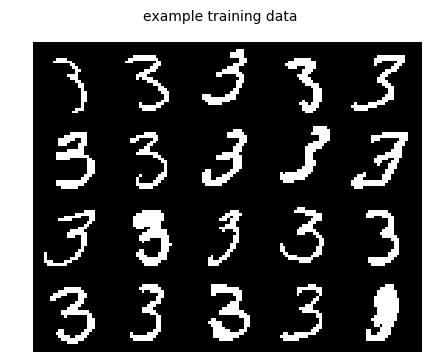

In [6]:
print_image(X_train[1160:1180, :], output_shape=(4, 5), 
            title='example training data')
None # should be binarized

## (a) Basic generalization

### Model initialization

Weights $W \in \mathbb{R}^{n_{hidden} \times n_{visible}}$ are initialized from a $\mathrm{Unif}(-u, u)$ where $u = \frac{\sqrt{6}}{\sqrt{n_{visible}+n_{hidden}}}$, as described in the lecture. Bias terms are initialized to zero.

Learning rate is initialized at 0.2, and is halved after every 100 epochs.

In [7]:
rbm = RBM(n_visible=784, n_hidden=100, k=1,
          learning_rate=0.2, early_stopping=True,
          seed=2)

In [8]:
rbm.W.shape, rbm.b.shape, rbm.c.shape

((100, 784), (100, 1), (784, 1))

### Training

Cross-entropy error is computed as the average over all training (or validation) dataset and summed over all dimensions.

In [9]:
n_epoch = 500
rbm.train(X_train, X_valid,
          batch_size=200, n_epoch=n_epoch, batch_seed=25, 
          verbose=True)
None

|-------|---------------------------|---------------------------|
| Epoch |         Training          |         Validation        |
|-------|---------------------------|---------------------------|
|   #   |       Cross-Entropy       |       Cross-Entropy       |
|-------|---------------------------|---------------------------|
|    1  |         220.89531         |         221.00531         |
|    2  |         173.15944         |         174.16221         |
|    3  |         154.11834         |         155.60616         |
|    4  |         144.56245         |         146.33024         |
|    5  |         138.07260         |         140.03615         |
|    6  |         132.53461         |         134.77639         |
|    7  |         128.07482         |         130.40619         |
|    8  |         124.56794         |         127.11107         |
|    9  |         121.37838         |         124.23135         |
|   10  |         118.72041         |         121.50982         |
|   11  | 

Next, we show the plots of training and validation errors. The validation error starts to go up at around 130 epochs.

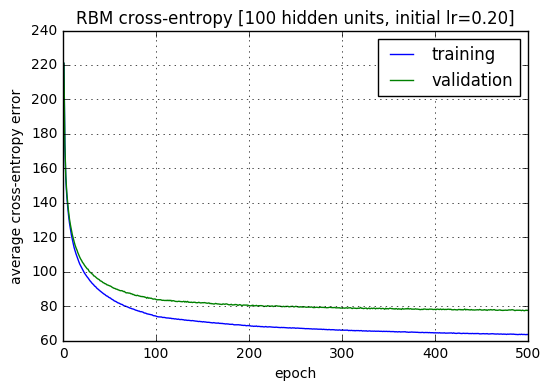

In [10]:
plt.grid()
plt.plot(*zip(*rbm.training_error), label='training')
plt.plot(*zip(*rbm.validation_error), label='validation')
plt.title('RBM cross-entropy [100 hidden units, initial lr={:.2f}]'.format(rbm.learning_rate.const))
plt.xlabel('epoch')
plt.ylabel('average cross-entropy error')
plt.legend()
plt.show()

As requested in the homework, we now train 5 more neural networks with different initializations.

In [11]:
rbms = [rbm]
for i in range(1, 6):
    rbm0 = RBM(n_visible=784, n_hidden=100, k=1,
               learning_rate=0.2, early_stopping=True,
               seed=44*i)
    rbm0.train(X_train, X_valid,
               batch_size=200, n_epoch=n_epoch, batch_seed=25, 
               verbose=False)  # silent run
    rbms.append(rbm0)
    print('RBM #{:d} training complete ({:d} epochs)'.format(i, n_epoch))
    print('Final training error: {:.5f}'.format(rbm0.training_error[-1][1]))
    print('Final validation error: {:.5f}'.format(rbm0.validation_error[-1][1]))

RBM #1 training complete (500 epochs)
Final training error: 62.90945
Final validation error: 77.32885
RBM #2 training complete (500 epochs)
Final training error: 62.77037
Final validation error: 77.72959
RBM #3 training complete (500 epochs)
Final training error: 63.06907
Final validation error: 77.36504
RBM #4 training complete (500 epochs)
Final training error: 62.97604
Final validation error: 77.16100
RBM #5 training complete (500 epochs)
Final training error: 63.57336
Final validation error: 77.23927


It appears that the validation cross-entropy errors are roughly the same across different initializations. We proceed with the first model.

### Visualizing parameters

First, we take the first hidden layer units and plot them as images. As shown below, the filters seem to capture digit-like shapes, as we saw with 2-layer feedforward neural networks. 

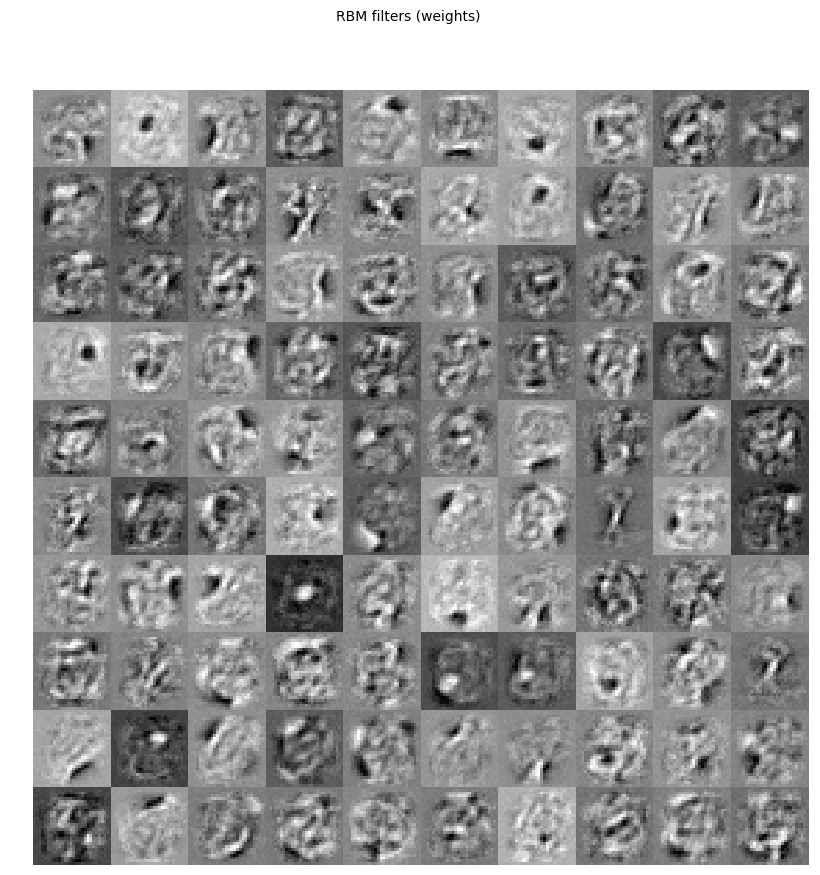

In [12]:
assert rbm.W.shape[0] >= 100
print_image(rbm.W[:100,:], output_shape=(10, 10),
            title='RBM filters (weights)')
None

Next, we generate 25 hidden states from a random sample of the training data of size 25. The hidden units don't appear to capture any particular structure.

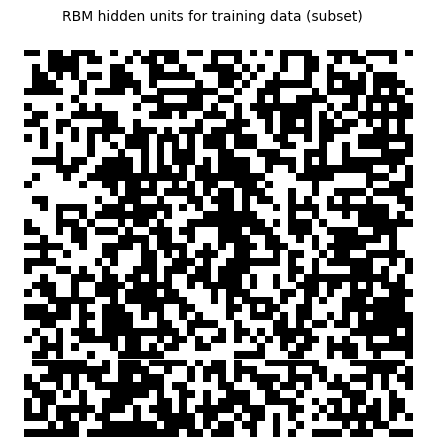

In [13]:
rng    = np.random.RandomState(1)
subset = rng.choice(np.arange(X_train.shape[0]), 25, replace=False)

hidden_units = rbm.sample_from_posterior(X_train[subset, :])
print_image(hidden_units, output_shape=(5, 5),
            title='RBM hidden units for training data (subset)')
None

Finally, we generate 25 new negative samples randomly generated from the trained RBM. These actually look pretty similar to real digits but with some noise.

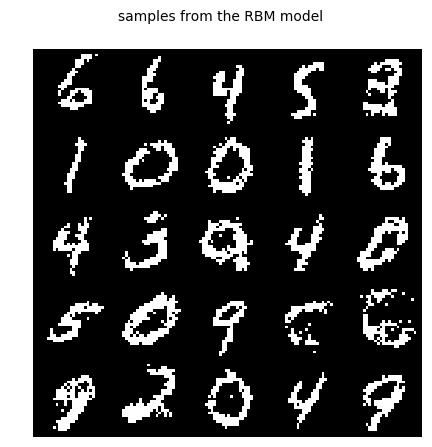

In [14]:
rng    = np.random.RandomState(1)
subset = rng.choice(np.arange(X_train.shape[0]), 25, replace=False)

X_neg = rbm.generate_negative_sample(X_train[subset, :])
print_image(X_neg, output_shape=(5, 5),
            title='samples from the RBM model')
None

## (b) Number of CD steps

Here, we try $k=5, 10, 20$ steps to generate the negative samples in the CD algorithm.

In [15]:
n_epoch = 400
rbms = []
ks = [5, 10, 20]
for i, k in enumerate(ks):
    rbm0 = RBM(n_visible=784, n_hidden=100, k=k,
               learning_rate=0.2, early_stopping=True,
               seed=100)
    rbm0.train(X_train, X_valid,
               batch_size=200, n_epoch=n_epoch, batch_seed=25, 
               verbose=False)  # silent run
    rbms.append(rbm0)
    print('RBM #{:d} (CD-k={:d}) training complete ({:d} epochs)'.format(i, k, n_epoch))
    print('Final training error: {:.5f}'.format(rbm0.training_error[-1][1]))
    print('Final validation error: {:.5f}'.format(rbm0.validation_error[-1][1]))

RBM #0 (CD-k=5) training complete (400 epochs)
Final training error: 66.55187
Final validation error: 78.73247
RBM #1 (CD-k=10) training complete (400 epochs)
Final training error: 68.92142
Final validation error: 80.38237
RBM #2 (CD-k=20) training complete (400 epochs)
Final training error: 70.50464
Final validation error: 81.74818


## (c) Samples from the RBM model

Here we take 100 samples of new images from the trained model by starting from 100 random visible units and running 1000 steps of Gibbs sampling for each of the 100 random inputs. 

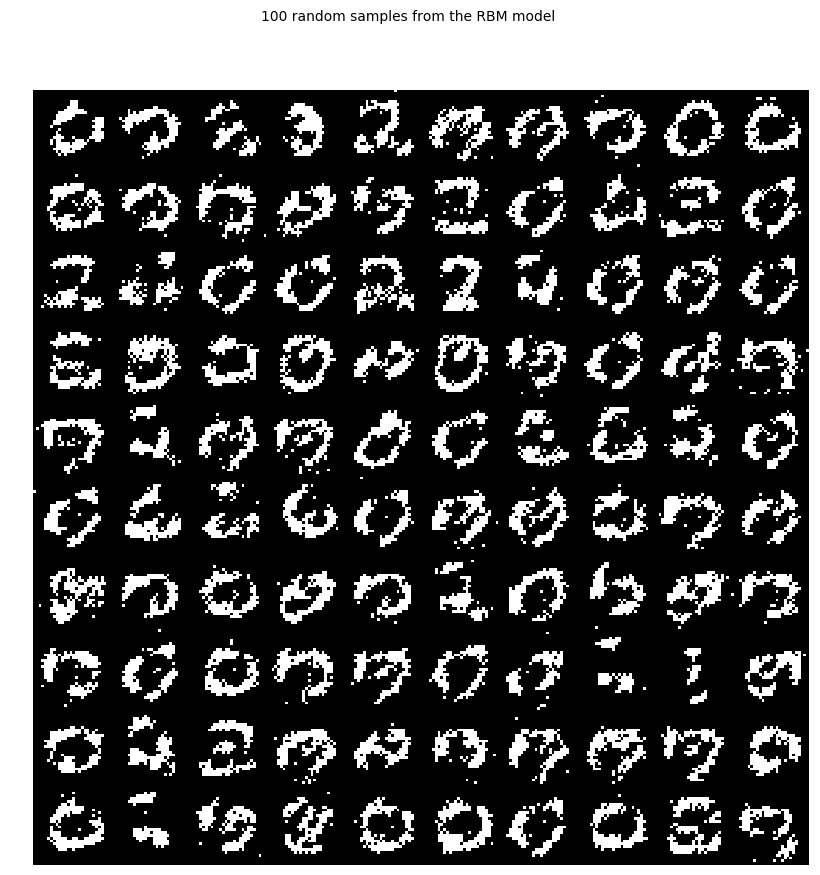

In [16]:
# Set the number of Gibbs steps to 1000
rbm.k    = 1000
# Generate random initial samples
X_random = rng.binomial(1, 0.5*np.ones((100, 784)))
# Run Gibbs steps
X_new    = rbm.generate_negative_sample(X_random)
# Reset to default
rbm.k    = 1
# Print digits
print_image(X_new, output_shape=(10, 10),
            title='100 random samples from the RBM model')
None

While they don't look like perfect digits, they definitely resemble some of the digits. We can perhaps fine-tune this model and run more extensively to obtain perfect digits.

## (d) Unsupervised learning as pre-training

Here we train a 1-layer neural network with weights learned from RBM and compare with randomly initialized weights.

In [17]:
# Random initialization
nn_random = NN(architecture=[784, 100, 10], 
               activation='sigmoid', learning_rate=0.01, momentum=0.7,
               weight_decay=1e-4, dropout=0.0, early_stopping=True, 
               seed=40)
nn_random.train(X_train, y_train, X_valid, y_valid,
                batch_size=200, n_epoch=n_epoch, batch_seed=25,
                verbose=False)  # silent run
None

In [18]:
# RBM-learned initialization
nn_rbm = NN(architecture=[784, 100, 10], 
            activation='sigmoid', learning_rate=0.01, momentum=0.7,
            weight_decay=1e-4, dropout=0.0, early_stopping=True, 
            seed=40)
nn_rbm.layers[0].W = rbm.W
nn_rbm.train(X_train, y_train, X_valid, y_valid,
             batch_size=200, n_epoch=n_epoch, batch_seed=25,
             verbose=False)  # silent run
None

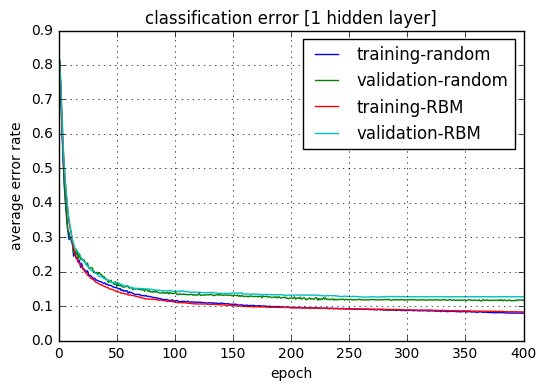

In [19]:
# Error rate
plt.grid()
plt.plot(*zip(*nn_random.training_error), label='training-random')
plt.plot(*zip(*nn_random.validation_error), label='validation-random')
plt.plot(*zip(*nn_rbm.training_error), label='training-RBM')
plt.plot(*zip(*nn_rbm.validation_error), label='validation-RBM')
plt.title('classification error [1 hidden layer]')
plt.xlabel('epoch')
plt.ylabel('average error rate')
plt.legend()
plt.show()

It appears that pre-training does not really help with the error rate. This is possible because RBM was only trained on the same number of examples (same training set, in fact) so that it will not necessarily give any new information. If we had a much larger unlabeled dataset, which is often the case in real applications, pre-training might give us a huge boost in performance.

## (g) Number of hidden units *[for RBM]*

###### See `autoencoder_mnist.ipynb` for this experiment with autoencoders.

Given the previous results, we use $k=1$ and vary the number of hidden units. 

In [20]:
rbms = []
n_hidden_units = [50, 100, 200, 500]
for i, n_hidden in enumerate(n_hidden_units):
    rbm0 = RBM(n_visible=784, n_hidden=n_hidden, k=1,
               learning_rate=0.2, early_stopping=True,
               seed=100)
    rbm0.train(X_train, X_valid,
               batch_size=200, n_epoch=n_epoch, batch_seed=25, 
               verbose=False)  # silent run
    rbms.append(rbm0)
    print('RBM #{:d} with {:d} hidden units training complete ({:d} epochs)'.format(i, n_hidden, n_epoch))
    print('Final training error: {:.5f}'.format(rbm0.training_error[-1][1]))
    print('Final validation error: {:.5f}'.format(rbm0.validation_error[-1][1]))

RBM #0 with 50 hidden units training complete (400 epochs)
Final training error: 91.73496
Final validation error: 100.66532
RBM #1 with 100 hidden units training complete (400 epochs)
Final training error: 63.94774
Final validation error: 77.90195
RBM #2 with 200 hidden units training complete (400 epochs)
Final training error: 40.51797
Final validation error: 59.44309
RBM #3 with 500 hidden units training complete (400 epochs)
Final training error: 20.89034
Final validation error: 43.58663


It appears that using more units directly lead to smaller cross-entropy error, at least within 200 epochs. One may want to worry about overfitting here. We generate 1000-step Gibbs samples from the 50-unit and 500-unit RBMs below (respectively):

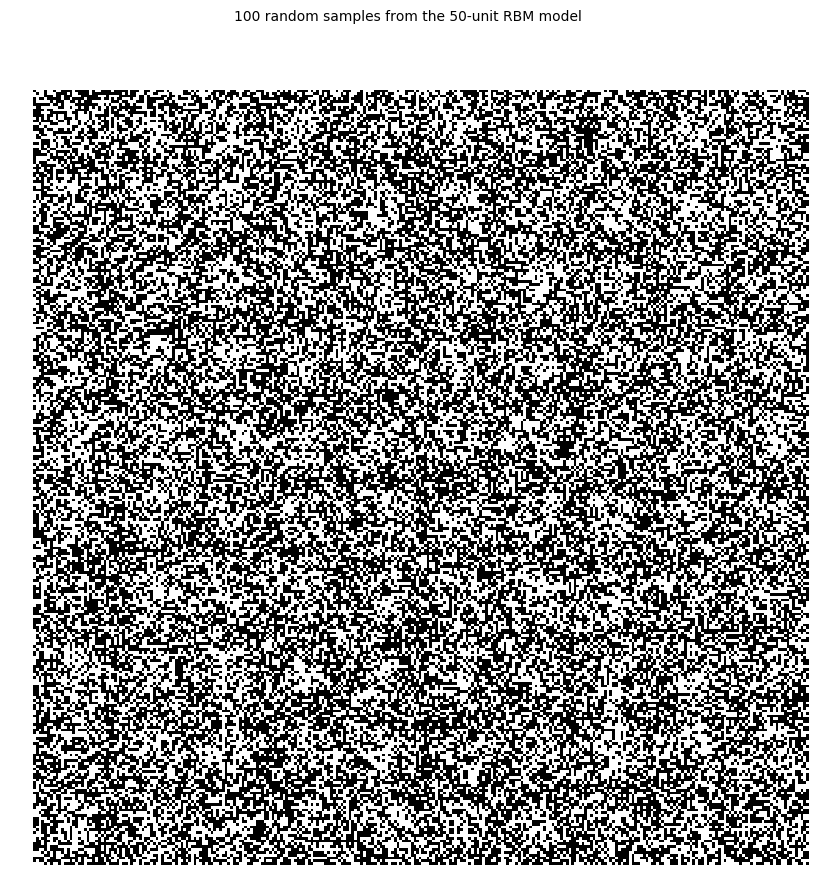

In [26]:
rbm50 = rbms[0]
# Set the number of Gibbs steps to 1000
rbm50.k    = 1000
# Generate random initial samples
X_random = rng.binomial(1, 0.5*np.ones((100, 784)))
# Run Gibbs steps
X_new    = rbm500.generate_negative_sample(X_random)
# Reset to default
rbm50.k    = 1
# Print digits
print_image(X_new, output_shape=(10, 10),
            title='100 random samples from the 50-unit RBM model')
None

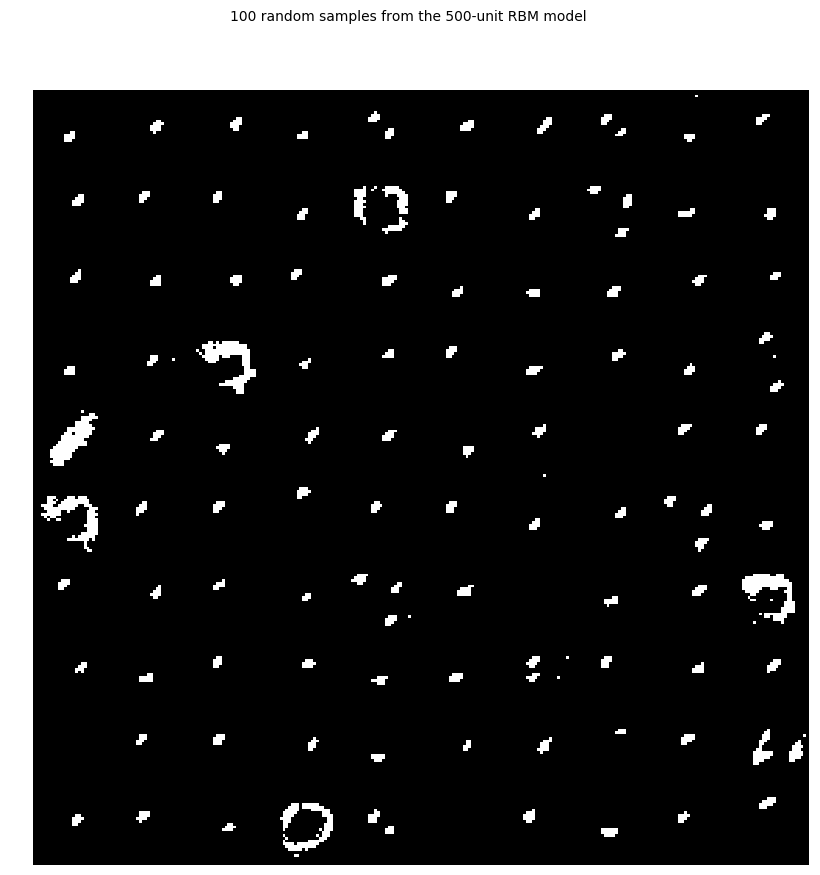

In [27]:
rbm500 = rbms[3]
# Set the number of Gibbs steps to 1000
rbm500.k    = 1000
# Generate random initial samples
X_random = rng.binomial(1, 0.5*np.ones((100, 784)))
# Run Gibbs steps
X_new    = rbm500.generate_negative_sample(X_random)
# Reset to default
rbm500.k    = 1
# Print digits
print_image(X_new, output_shape=(10, 10),
            title='100 random samples from the 500-unit RBM model')
None

While the 50-unit model is clearly underfitting, the 500-unit model effectively prints dots, which implies saturating to specific locations too fast. Our 100-unit model does the best so far, but we can improve these results further by optimizing hyperparameters for each number of units.